### Setup notebook paramaters

In [1]:
import numpy as np
import pandas as pd
import os
import sys

from kde.location_project.kde_2d import (
    kdnearest, 
    learn_nearest_neighbors_bandwidth, 
    plot_kde,
    sample_from_kde
)
from kde.location_project.cmp import (
    calc_cmp,
    plot_scatter
)

import matplotlib.pyplot as plt
import plotly
from plotly.offline import (
    download_plotlyjs, init_notebook_mode, plot, iplot
)
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline
init_notebook_mode(connected=True)

sys.setrecursionlimit(10000)
# # turn off SettingWithCopyWarning
# pd.options.mode.chained_assignment = None 

%load_ext autoreload
%autoreload 2

np.random.seed(1234)
directory = os.path.join("..", "data") 

### Load the visits data & test integrity

In [2]:
mpp = pd.read_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n20.csv"))
pop_deduped = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped_bw.csv"))
pop_kde_data = np.array(pop_deduped[['uid', 'lon', 'lat', 'bw']])


In [3]:
plot_scatter(mpp=mpp, df=pop_deduped, uid=1)

In [4]:
calc_cmp(mpp, pop_kde_data, userA=1, n_sim=100, k=1, prnt=True)

USERS {1}
Number of unique locations (across A & B): 31
Number of locations in common (in both A & B): 5
Number of matched users: 11
Number of sample points: 1253
Sum of weights: 1.0



(0.01, 0.33, 1.418316904988363, 0.21305388248339802)

In [5]:
calc_cmp(mpp, pop_kde_data, userA=1, userB=4, n_sim=100, k=1, prnt=True)

USERS {1, 4}
Number of unique locations (across A & B): 27
Number of locations in common (in both A & B): 0
Number of matched users: 21
Number of sample points: 2463
Sum of weights: 1.0



(1.0, 1.0, 17.873691478407267, 13.960645286040574)

# Earth Mover's Distance

## Explore on simulated data

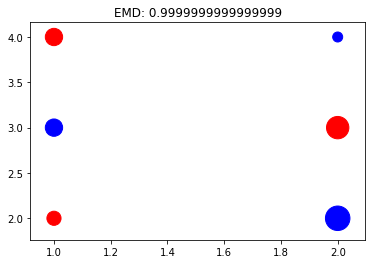

In [6]:
from emd import emd

X = np.array([[1,2], [1,4], [2,3]])
X_wts = np.atleast_2d(np.array([0.2, 0.3, 0.5])).T
Y = np.array([[1,3], [2,2], [2,4]])
Y_wts = np.atleast_2d(np.array([0.3, 0.6, 0.1])).T

# EMD is symmetric
assert(emd(X, Y, X_weights=X_wts, Y_weights=Y_wts) \
    == emd(Y, X, X_weights=Y_wts, Y_weights=X_wts))

# plot it
plt.scatter(X[:,0], X[:,1], s=X_wts*1000, c='red')
plt.scatter(Y[:,0], Y[:,1], s=Y_wts*1000, c='blue')
plt.title("EMD: {}".format(emd(X, Y, X_weights=X_wts, Y_weights=Y_wts)))
plt.show()

### Simulate from a 2d normal & add noise for second point pattern

EMD scales linearly as the distance between points increases.

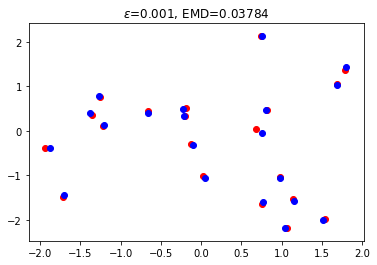

In [7]:
X = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[1, 0], [0, 1]],
    size=20
)
eps = 0.001
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=20
)
plt.scatter(X[:,0], X[:,1], c='red')
plt.scatter(Y[:,0], Y[:,1], c='blue')
plt.title("$\epsilon$={}, EMD={}".format(eps, round(emd(X, Y),5)))
plt.show()

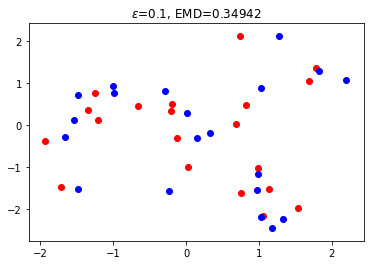

In [8]:
eps = 0.1
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=20
)
plt.scatter(X[:,0], X[:,1], c='red')
plt.scatter(Y[:,0], Y[:,1], c='blue')
plt.title("$\epsilon$={}, EMD={}".format(
    eps, 
    round(emd(X, Y),5))
)
plt.show()

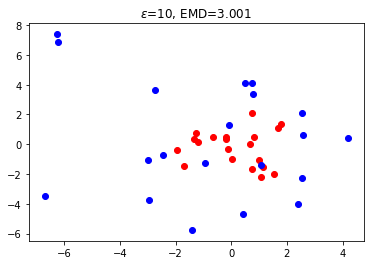

In [9]:
eps = 10
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=20
)
plt.scatter(X[:,0], X[:,1], c='red')
plt.scatter(Y[:,0], Y[:,1], c='blue')
plt.title("$\epsilon$={}, EMD={}".format(
    eps, 
    round(emd(X, Y),5))
)
plt.show()

### Unequal number of points

Appears to only have an impact when $\epsilon$ is small, which could result in larger distances for same-source pairs.

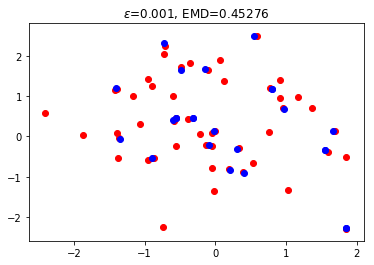

In [10]:
X = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[1, 0], [0, 1]],
    size=50
)
eps = 0.001
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=50
)
Y = Y[np.random.randint(0,len(X),25), :]
plt.scatter(X[:,0], X[:,1], c='red')
plt.scatter(Y[:,0], Y[:,1], c='blue')
plt.title("$\epsilon$={}, EMD={}".format(eps, round(emd(X, Y),5)))
plt.show()

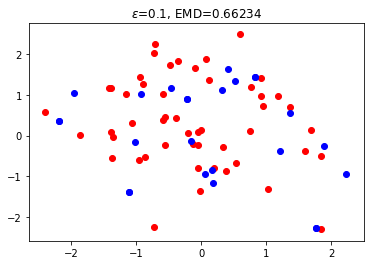

In [11]:
eps = 0.1
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=50
)
Y = Y[np.random.randint(0,len(X),25), :]
plt.scatter(X[:,0], X[:,1], c='red')
plt.scatter(Y[:,0], Y[:,1], c='blue')
plt.title("$\epsilon$={}, EMD={}".format(eps, round(emd(X, Y),5)))
plt.show()

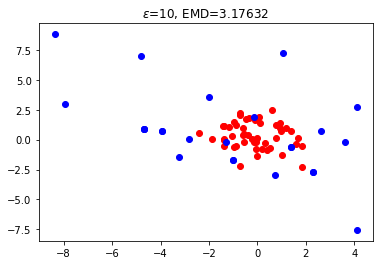

In [12]:
eps = 10
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=50
)
Y = Y[np.random.randint(0,len(X),25), :]
plt.scatter(X[:,0], X[:,1], c='red')
plt.scatter(Y[:,0], Y[:,1], c='blue')
plt.title("$\epsilon$={}, EMD={}".format(eps, round(emd(X, Y),5)))
plt.show()

### Incorporating weights

Similar effect as unequal numbers of points, but higher variability across simulated point sets when $\epsilon$ is low (not shown in this notebook).

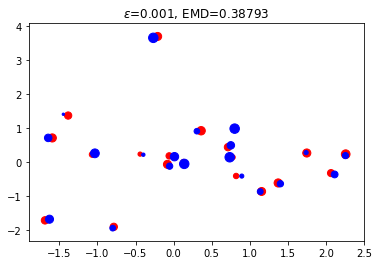

In [13]:
X = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[1, 0], [0, 1]],
    size=20
)
X_wts = np.random.uniform(0,1,20)
X_wts /= sum(X_wts)
eps = 0.001
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=20
)
Y_wts = np.random.uniform(0,1,20)
Y_wts /= sum(Y_wts)
plt.scatter(X[:,0], X[:,1], s=X_wts*1000, c='red')
plt.scatter(Y[:,0], Y[:,1], s=Y_wts*1000, c='blue')
plt.title("$\epsilon$={}, EMD={}".format(
    eps, 
    round(emd(X, Y, X_weights=X_wts, Y_weights=Y_wts),5))
)
plt.show()

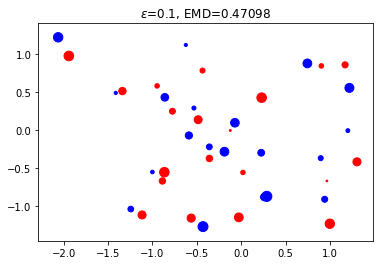

In [14]:
X = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[1, 0], [0, 1]],
    size=20
)
X_wts = np.random.uniform(0,1,20)
X_wts /= sum(X_wts)
eps = 0.1
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=20
)
Y_wts = np.random.uniform(0,1,20)
Y_wts /= sum(Y_wts)
plt.scatter(X[:,0], X[:,1], s=X_wts*1000, c='red')
plt.scatter(Y[:,0], Y[:,1], s=Y_wts*1000, c='blue')
plt.title("$\epsilon$={}, EMD={}".format(
    eps, 
    round(emd(X, Y, X_weights=X_wts, Y_weights=Y_wts),5))
)
plt.show()

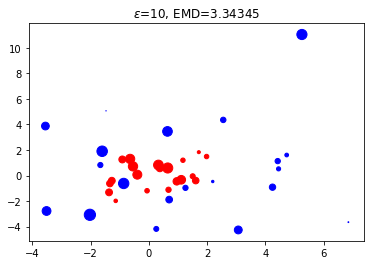

In [15]:
X = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[1, 0], [0, 1]],
    size=20
)
X_wts = np.random.uniform(0,1,20)
X_wts /= sum(X_wts)
eps = 10
Y = X + np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[eps, 0], [0, eps]],
    size=20
)
Y_wts = np.random.uniform(0,1,20)
Y_wts /= sum(Y_wts)
plt.scatter(X[:,0], X[:,1], s=X_wts*1000, c='red')
plt.scatter(Y[:,0], Y[:,1], s=Y_wts*1000, c='blue')
plt.title("$\epsilon$={}, EMD={}".format(
    eps, 
    round(emd(X, Y, X_weights=X_wts, Y_weights=Y_wts),5))
)
plt.show()